In [1]:
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import MySVM as mysvc
import Superplot

In [2]:
from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
from scipy.interpolate import spline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.gaussian_process import GaussianProcess
import timeit
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy.interpolate import spline
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
import re
from astropy.io.fits.header import Header
from matplotlib.pyplot import xlim
from sklearn import svm
%matplotlib inline


In [5]:

# Load data set and target values
start = timeit.default_timer()

####### Read the source data######################
df =pd.read_csv('Source_Data.csv', header=0)


p= Preprocessdata.standardprocess()

save_path = '/home/peng/git/Machine_learning_for_reliability_analysis/Kernel/Results/'
result_name = 'j1_rbf_pca_train_v1.csv'

seed = 'rbf'
rad_stat = 2

#train, trainlabel, test, testlabel = p.scaledivd(df, 0.8)
#print (np.shape(train))

In [4]:
#### scale the training dataset first and then apply the rules to test set 
train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.8)
#print (test[0:10])


In [5]:
# use the new features to train

ff = mysvc.training_manCV()

df = ff.trainauc(train, trainlabel, 'rbf', Cmin=-10, Cmax=10, numC=21, rmin=-10, rmax=10, numr=21, degree = 3,
                rad_stat = rad_stat)

df.to_csv(save_path + 'j1_rbf_origin_train_auc_1.csv', header = True)


0.780250512904
1 cycle finished, 20 left
0.7808632977
2 cycle finished, 19 left
0.781022567757
3 cycle finished, 18 left
0.781234477918
4 cycle finished, 17 left
0.781623204837
5 cycle finished, 16 left
0.78290276428
6 cycle finished, 15 left
0.783101176979
7 cycle finished, 14 left
0.784124284634
8 cycle finished, 13 left
0.789211478242
9 cycle finished, 12 left
0.790214339704
10 cycle finished, 11 left
0.790632761041
11 cycle finished, 10 left
0.785649497894
12 cycle finished, 9 left
0.781773026671
13 cycle finished, 8 left
0.780490767736
14 cycle finished, 7 left
0.777143397041
15 cycle finished, 6 left
0.773029370478
16 cycle finished, 5 left
0.76927707591
17 cycle finished, 4 left
0.764323507181
18 cycle finished, 3 left
0.762196307094
19 cycle finished, 2 left
0.756889104848
20 cycle finished, 1 left
0.751284958428
21 cycle finished, 0 left


In [14]:
#load the results from the saved file

df =pd.read_csv(save_path + 'j1_rbf_origin_train_auc_1.csv', header = 0)
#print (df.columns.values)

['Unnamed: 0' 'gamma_range' '0.0009765625' '0.001953125' '0.00390625'
 '0.0078125' '0.015625' '0.03125' '0.0625' '0.125' '0.25' '0.5' '1.0' '2.0'
 '4.0' '8.0' '16.0' '32.0' '64.0' '128.0' '256.0' '512.0' '1024.0']


In [19]:
df_new = df.drop('gamma_range',1)
df_new = df_new.drop('Unnamed: 0',1)

list_c = df_new.columns.values.tolist()
idx_C, idx_gamma = [],[]
for i in list_c:
    for j in xrange(0,21):
        if df[i][j]== (df_new.values.max()):
            
            idx_C.append(i)
            idx_gamma.append(j)
        else:
            pass
print (idx_C)
print (idx_gamma)       

['0.5']
[14]


In [23]:
# if only got unique maximum value, then check 

C_best = idx_C[0]
gamma_best = idx_gamma[0]

print (df[C_best][gamma_best], df_new.values.max())
C_best = np.float(C_best)
gamma_best = np.float(gamma_best)

0.853401360544 0.853401360544


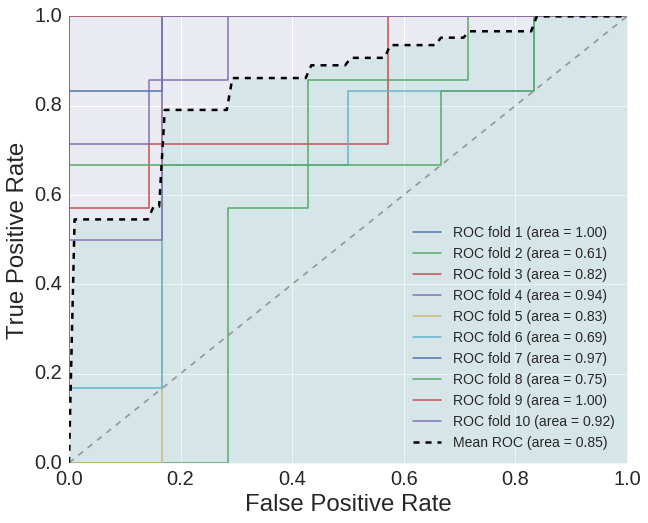

In [24]:
#use the best parameters to plot cv auc on the training set
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

figsize(10,8)
cv = StratifiedKFold(trainlabel, n_folds=10)

bestmodel_training= svm.SVC(kernel=seed, C= C_best, gamma= gamma_best, probability=True, 
                            random_state = rad_stat)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (training, testing) in enumerate(cv):
    probas_ = bestmodel_training.fit(train[training], trainlabel[training]).predict_proba(train[testing])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(trainlabel[testing], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2.5)

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 14)

plt.fill_between(mean_fpr, 0, mean_tpr, #color="#348ABD", 
                 color="#66cdaa", alpha=0.15)
plt.show()

In [26]:
#predict the test set

tt=mysvc.test()
result = tt.test_classification(test, testlabel,bestmodel_training)

This is for test set**************************************
('The accuracy for the test set is 0.78125', 'and the confusion matrix is')
[[13  4]
 [ 3 12]]
             precision    recall  f1-score   support

        0.0       0.76      0.81      0.79        16
        1.0       0.80      0.75      0.77        16

avg / total       0.78      0.78      0.78        32



[[13  4]
 [ 3 12]]
*******************************************


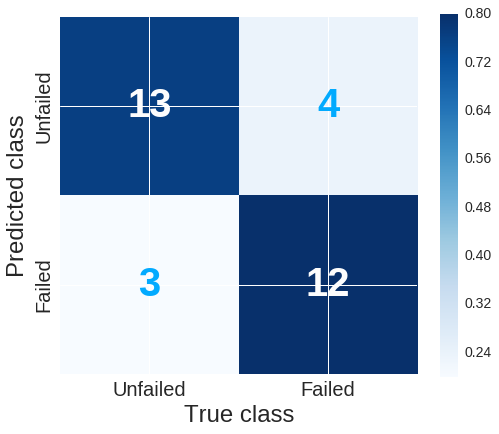

In [27]:
#plot the confusion matrix on test set

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report
print (confusion_matrix(result, testlabel))
pp = Superplot.fancy()
pp.plot_confusion_matrix(confusion_matrix(result, testlabel))

In [28]:
#plot the auc on test set
from sklearn.metrics import roc_curve, auc

y_score = bestmodel_training.predict_proba(test)
#print (y_score)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

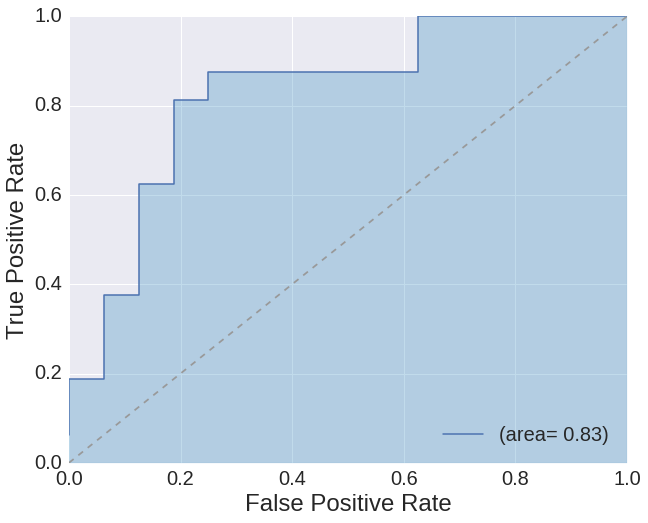

In [12]:
#plot the auc on test set
fpr, tpr, thresholds = roc_curve(testlabel, y_score[:, 1])
roc_auc = auc(fpr, tpr)

figsize(10,8)

plt.plot(fpr, tpr, lw=1.5, label='(area= %0.2f)' % ( roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate',fontsize = 24)
plt.ylabel('True Positive Rate',fontsize = 24)
plt.xticks(fontsize = 20) 

plt.yticks(fontsize = 20) 

#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right",fontsize = 20)
sec = np.arange(0.0, 1.0, 0.05)
plt.fill_between(fpr, 0, tpr, color="#348ABD", alpha=0.3)
plt.show()

In [30]:
df_score = pd.DataFrame({'y_origin': y_score[:,1]})
print (df_score)

    y_origin
0   0.425796
1   0.093462
2   0.801894
3   0.486475
4   0.874951
5   0.693929
6   0.756607
7   0.802247
8   0.889455
9   0.318547
10  0.786703
11  0.095120
12  0.357004
13  0.889554
14  0.876071
15  0.127363
16  0.666791
17  0.480615
18  0.100372
19  0.372697
20  0.761941
21  0.480325
22  0.916240
23  0.110802
24  0.699944
25  0.489988
26  0.710655
27  0.761941
28  0.361382
29  0.312158
30  0.469538
31  0.102339


In [31]:
df_score.to_csv(save_path +'y_score_comp.csv', header = True)

(21, 21)


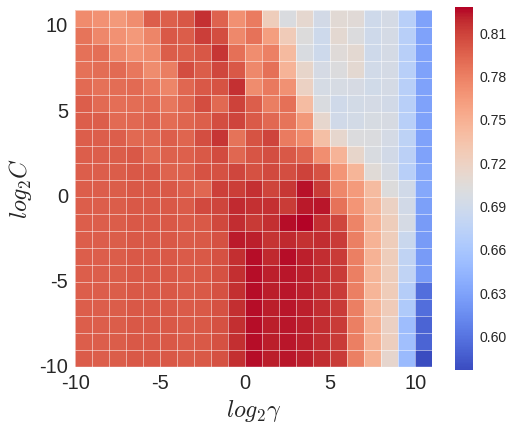

In [10]:
#plot the grid search


df = pd.read_csv(save_path+'j1_rbf_tree_train_auc_1.csv', header = 0)

scores=np.array(df)
scores=scores[:, 2:].T
#    print scores
#scores= scores[:,5:]
print (np.shape(scores))

#    print np.arange(100,2010,20)

figsize(8,6.5)
fig, ax = plt.subplots(1,1)
cax = ax.imshow(scores, interpolation='none', origin='highest',
                cmap=plt.cm.coolwarm, aspect=1)

plt.grid(b=False, which='x', color='white',linestyle='-')




plt.xticks(np.arange(-0.5,21.5,5), (-10,-5,0,5,10),fontsize = 20)
plt.yticks(np.arange(-0.5,23.5,5), (-10,-5,0,5,10),fontsize = 20)

#plt.yticks(np.arange(0,11,1), np.arange(1,12,1), fontsize = 20)

plt.ylabel('$log_2 C$',fontsize = 24)
plt.xlabel('$log_2 \gamma$', fontsize = 24)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=0.5)
ax.grid(b=True, which='minor', color='w', linewidth=0.5)


cb = fig.colorbar(cax)
cb.ax.tick_params(labelsize=14)


plt.show()